# 프로젝트 : 개구리는 안돼요! (CIFAR-10)

이번 프로젝트는 지금까지의 실습과 동일한 방법으로 CIFAR-10 데이터셋에 대해 진행해보겠습니다.

만들 모델은 CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델입니다. 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경과를 발생시키는 개구리 감지 모델이라고 할 수 있겠습니다.

아래 순서를 따라 진행해주세요.

- 이상 감지용 데이터셋 구축 (개구리 데이터를 학습 데이터셋에서 제외하며 테스트 데이터셋에 포함)
- Skip-GANomaly 모델의 구현
- 모델의 학습과 검증
- 검증 결과의 시각화 (정상 - 이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이상감지율 계산, 감지 성공/실패 사례 시각화 포함)

In [1]:
#필요한 모듈 import
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

## Step 1. 이상감지 데이터셋 구축

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

In [4]:
train_data.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

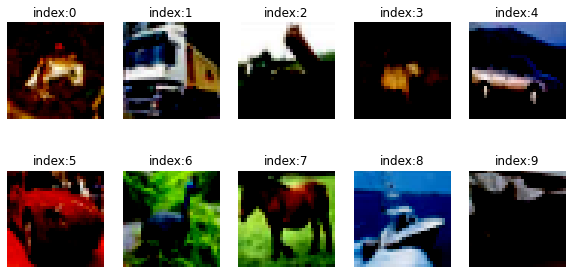

In [12]:
from PIL import Image

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index:{i}')
    plt.axis('off')
plt.show()

In [19]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

개구리 라벨은 6번입니다. 이상 데이터로 선정된 6번 라벨 데이터를 제외하도록 합시다.

In [30]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:
            #print(old_label)
            new_t_labels.append([0]) # 이상치로 처리
        else:
            new_t_labels.append([1])
    return new_t_labels

In [31]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [36]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []

for data, label in zip(train_data, bol_train_labels):
    if label == [0]:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [37]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [38]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [39]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [40]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


50000건의 데이터를 잘 나눈 것 같습니다. 개구리만 5000장이나 있네요?

In [44]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


데이터셋을 구성하고 label을 검증해봅시다. 

훈련 데이터셋에는 라벨이 1인 데이터만 존재하고 테스트 데이터에는 0과 1이 섞여있어야 합니다.

In [45]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [46]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [48]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]], shape=(8, 1), dtype=int32)


## Step 2. Skip-GANomaly 모델의 구현


### Generator

In [89]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [90]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [79]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel = 3):
        super(Generator, self).__init__()
        
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2,
                                                  padding='same', use_bias=False,
                                                  kernel_initializer=tf.random_normal_initializer(0., 0.02))
        
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator

Discriminator도 Generator처럼 Conv_block을 활용하며, 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴합니다.



In [80]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                    use_bias = False, activation='sigmoid')
        
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [91]:
generator = Generator(num_output_channel=3)
discriminator = Discriminator()

### Loss 함수

GAN 모델의 핵심은 Loss 함수의 구성방법에 달려 있다고 해도 과언이 아닙니다. Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행됩니다.

In [82]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [83]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [84]:
def generator_loss(real_output, fake_output, 
                   input_data, gen_data, 
                   latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
        w_context * context_loss + \
        w_encoder * encoder_loss

    return total_gen_loss

In [85]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## Step 3. 모델 학습과 검증

### Model Train

본격적으로 모델을 학습시켜봅시다!

In [86]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [87]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
    
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [93]:
max_epochs = 5
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 1 == 0:
        checkpoint.save(checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 26.599557876586914, 	 Total Dis Loss : 0.001720196334645152
Steps : 200, 	 Total Gen Loss : 28.153732299804688, 	 Total Dis Loss : 0.004021925386041403
Steps : 300, 	 Total Gen Loss : 24.85429573059082, 	 Total Dis Loss : 0.0010040960041806102
Steps : 400, 	 Total Gen Loss : 20.88897132873535, 	 Total Dis Loss : 0.002625041175633669
Steps : 500, 	 Total Gen Loss : 23.213520050048828, 	 Total Dis Loss : 0.001350597944110632
Steps : 600, 	 Total Gen Loss : 21.140586853027344, 	 Total Dis Loss : 0.001834370894357562
Steps : 700, 	 Total Gen Loss : 26.333003997802734, 	 Total Dis Loss : 0.0006029372452758253
Steps : 800, 	 Total Gen Loss : 20.940448760986328, 	 Total Dis Loss : 0.002944812411442399
Steps : 900, 	 Total Gen Loss : 20.459575653076172, 	 Total Dis Loss : 0.0008829345460981131
Steps : 1000, 	 Total Gen Loss : 19.959625244140625, 	 Total Dis Loss : 0.005904758349061012
Steps : 1100, 	 Total Gen Loss : 27.42235565185547, 	 Total Dis Loss : 0.00421

Steps : 8900, 	 Total Gen Loss : 22.987178802490234, 	 Total Dis Loss : 0.0005946144228801131
Steps : 9000, 	 Total Gen Loss : 25.530370712280273, 	 Total Dis Loss : 0.00040964604704640806
Steps : 9100, 	 Total Gen Loss : 23.11440086364746, 	 Total Dis Loss : 0.0005223599728196859
Steps : 9200, 	 Total Gen Loss : 23.904560089111328, 	 Total Dis Loss : 0.0008143869345076382
Steps : 9300, 	 Total Gen Loss : 24.018875122070312, 	 Total Dis Loss : 0.0014595839893445373
Steps : 9400, 	 Total Gen Loss : 26.30617332458496, 	 Total Dis Loss : 0.0011058237869292498
Steps : 9500, 	 Total Gen Loss : 22.738971710205078, 	 Total Dis Loss : 0.0005065264413133264
Steps : 9600, 	 Total Gen Loss : 23.387592315673828, 	 Total Dis Loss : 0.0006531958933919668
Steps : 9700, 	 Total Gen Loss : 23.168407440185547, 	 Total Dis Loss : 0.00036161692696623504
Steps : 9800, 	 Total Gen Loss : 22.49827003479004, 	 Total Dis Loss : 0.00041362910997122526
Steps : 9900, 	 Total Gen Loss : 23.352140426635742, 	 Total

Steps : 17500, 	 Total Gen Loss : 25.47000503540039, 	 Total Dis Loss : 0.00037722045090049505
Steps : 17600, 	 Total Gen Loss : 25.089515686035156, 	 Total Dis Loss : 0.00013479817425832152
Steps : 17700, 	 Total Gen Loss : 25.119949340820312, 	 Total Dis Loss : 0.00039011065382510424
Steps : 17800, 	 Total Gen Loss : 25.595638275146484, 	 Total Dis Loss : 0.00010469598055351526
Steps : 17900, 	 Total Gen Loss : 25.220947265625, 	 Total Dis Loss : 7.233826909214258e-05
Steps : 18000, 	 Total Gen Loss : 24.707977294921875, 	 Total Dis Loss : 0.000280372507404536
Steps : 18100, 	 Total Gen Loss : 25.80998420715332, 	 Total Dis Loss : 0.0005242583574727178
Steps : 18200, 	 Total Gen Loss : 27.511253356933594, 	 Total Dis Loss : 0.00010227962047792971
Steps : 18300, 	 Total Gen Loss : 27.68001937866211, 	 Total Dis Loss : 0.355838805437088
Steps : 18400, 	 Total Gen Loss : 26.55247688293457, 	 Total Dis Loss : 0.001136715873144567
Steps : 18500, 	 Total Gen Loss : 29.292104721069336, 	 To

Steps : 26100, 	 Total Gen Loss : 28.634815216064453, 	 Total Dis Loss : 0.0005208835937082767
Steps : 26200, 	 Total Gen Loss : 28.341089248657227, 	 Total Dis Loss : 0.0004232387582305819
Steps : 26300, 	 Total Gen Loss : 30.55772590637207, 	 Total Dis Loss : 9.993785351980478e-05
Steps : 26400, 	 Total Gen Loss : 29.10812759399414, 	 Total Dis Loss : 0.0012847951147705317
Steps : 26500, 	 Total Gen Loss : 25.634307861328125, 	 Total Dis Loss : 0.003317257622256875
Steps : 26600, 	 Total Gen Loss : 25.94975471496582, 	 Total Dis Loss : 0.00033227595849893987
Steps : 26700, 	 Total Gen Loss : 28.958904266357422, 	 Total Dis Loss : 0.0005574804381467402
Steps : 26800, 	 Total Gen Loss : 30.20517349243164, 	 Total Dis Loss : 4.613501369021833e-05
Steps : 26900, 	 Total Gen Loss : 30.466785430908203, 	 Total Dis Loss : 0.0001448128023184836
Steps : 27000, 	 Total Gen Loss : 28.409177780151367, 	 Total Dis Loss : 0.0015518636209890246
Steps : 27100, 	 Total Gen Loss : 28.91691780090332, 	

In [94]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

## Step 4. 모델 평가하기

In [95]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [96]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [97]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


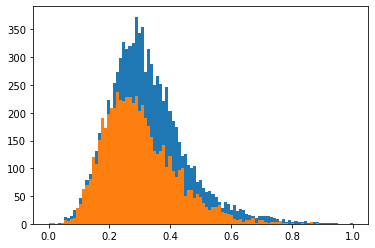

In [98]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3252508 0.2992694
0.12729788 0.11795122


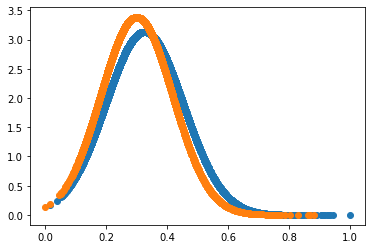

In [99]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

모델을 만들고 학습가지 시켜보았습니다! 

normal 데이터와 anomaly 데이터의 분포 차이가 있습니다. 개구리 사진이 나오면 이상하다고 잘 탐지할 수 있겠죠?